## Задание 3

## Подсчёт количества объектов на изображении

#### Описание датасета
В качестве датасета была выбрана коллекция изображений монет различных стран: США, Мексика, Китай, Япония, Европа, Индия. Описание датасета и архив с данными доступны [на странице в Kaggle](https://www.kaggle.com/datasets/balabaskar/count-coins-image-dataset/data).

Файл `coins_count_values.csv` содержит ground truth-значения количества монет на каждом изображении, подсчитанные вручную.

#### Проблемы, которые нужно решить:
- Не все монеты круглой формы
- Разный цвет и размер монет, рисунки и блики
- Монеты, бывает, касаются или наложены друг на друга
- Азиатские монеты часто имеют пустое отверстие в центре

Датасет содержит изображения монет на различном фоне, что сильно усложнит задачу, поэтому были выбраны изображения только с белым фоном. Они помещены в папку `white_coins/`. Всего 132 изображения.

### Поиск параметров препроцессинга
Обработаем одно изображение, чтобы найти подходящие параметры для функций. Выберем достаточно "сложное" изображение (разный цвет и размер монет, блики, наложение монет друг на друга и т.д.).

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

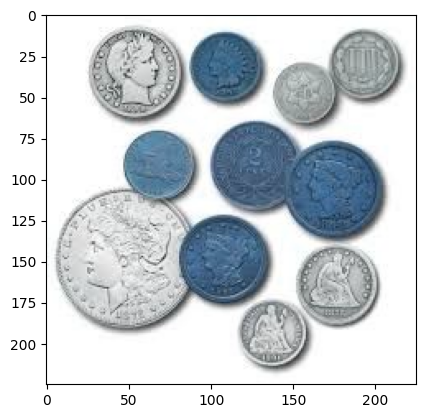

In [4]:
img = cv.imread("white_coins\\5ab456ac02.jpg")
plt.imshow(img)

Заметим, что белый фон мало отличается от внутренней области некоторых монет, что помешает дальнейшей бинаризации. Размоем границы и рисунки на монетах, чтобы они стали темнее.

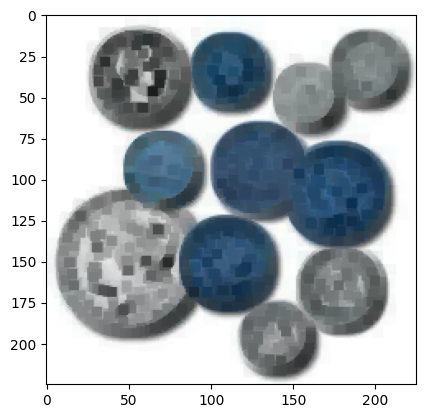

In [ ]:
kernel = np.ones((2,2),np.uint8)
erosion = cv.erode(img, kernel, iterations=5)
plt.imshow(erosion)

Переведём изображение в оттенки серого.

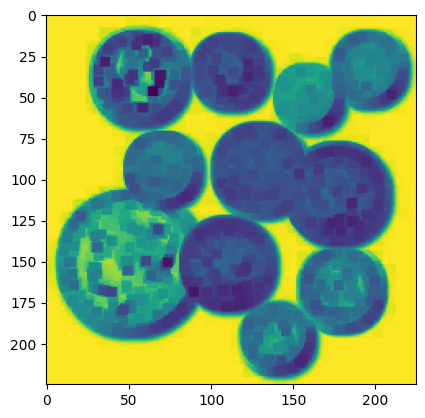

In [ ]:
gray = cv.cvtColor(erosion, cv.COLOR_BGR2GRAY)
plt.imshow(gray)

Построим гистограмму, чтобы определить оптимальный порог бинаризации.

(array([  368.,  5412.,  8133.,  6184.,  4321.,  3477.,  1832.,  1407.,
         1193., 18298.]),
 array([ 29. ,  51.6,  74.2,  96.8, 119.4, 142. , 164.6, 187.2, 209.8,
        232.4, 255. ]),
 <BarContainer object of 10 artists>)

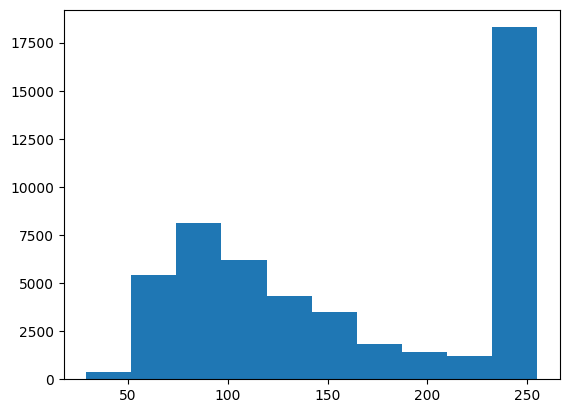

In [ ]:
plt.hist(gray.flatten())

Бинаризуем с порогом 235.

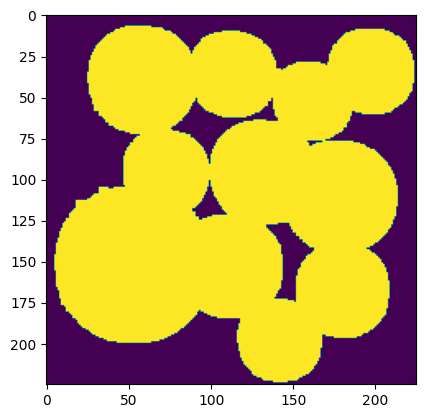

In [ ]:
_, thresh = cv.threshold(gray, 235, 255, cv.THRESH_BINARY_INV)
plt.imshow(thresh)

На случай если эрозия недостаточно размыла внутреннюю область монет, нарастим объекты, чтобы заполнить пустоты.

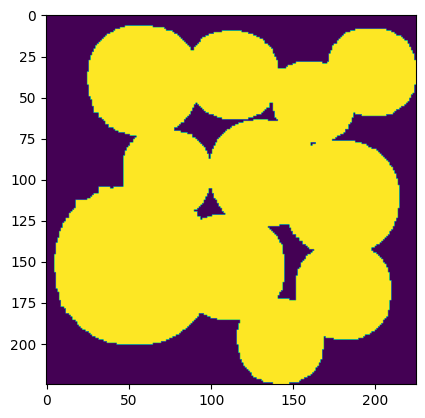

In [ ]:
kernel = np.ones((2,2), np.uint8)
dilate = cv.dilate(thresh, kernel, iterations=1)
plt.imshow(dilate)

Применим морфологическое преобразование, чтобы разделить касающиеся монеты.

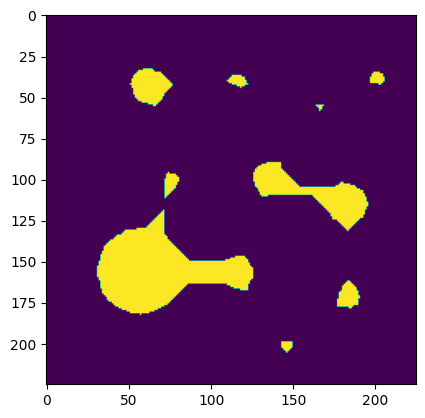

In [ ]:
kernel_erode = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
errode = cv.erode(dilate, kernel_erode, iterations=11)
plt.imshow(errode)

Видим, что из-за разницы в размерах монет некоторые монеты отделились, а некоторые нет. При этом увеличение числа итераций функции `erode` приведёт к тому, что маленькие монеты пропадут с изображения.

Попробуем разбить монеты с изображения на 2 класса: большие и маленькие. Найдем площади компонент. Если площадь > 1000, монеты считаются неразделенными и подвергнутся повторному `erode`, при этом монеты с площадью < 1000 считаются уже разделенными и останутся без изменений.

Components: 9
Areas: [45388   439    55   104     8  1219    83  3137   155    37]


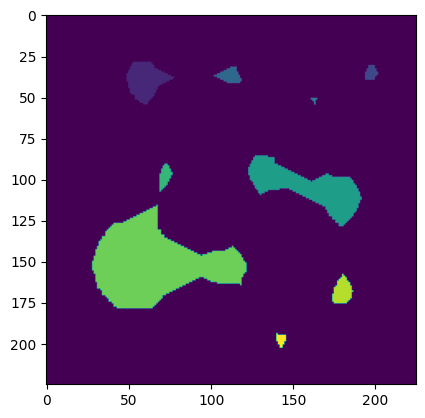

In [ ]:
output = cv.connectedComponentsWithStats(errode, stats=cv.CC_STAT_AREA)
print(f'Components: {output[0] - 1}\nAreas: {output[2][:,4]}')
plt.imshow(output[1])

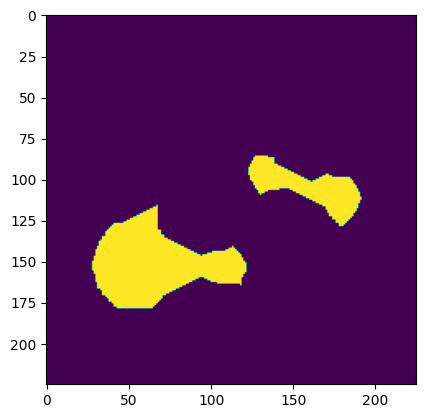

In [ ]:
big_labels = np.argwhere(output[2][:,4] > 1000).flatten()
big_objects = np.zeros(errode.shape)
for label in big_labels:
    if label != 0:
        big_objects[output[1] == label] = 1
plt.imshow(big_objects)

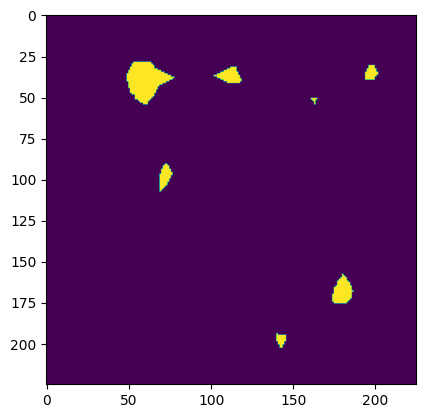

In [ ]:
small_labels = np.argwhere(output[2][:,4] <= 1000).flatten()
small_objects = np.zeros(errode.shape)
for label in small_labels:
    if label != 0:
        small_objects[output[1] == label] = 1
plt.imshow(small_objects)

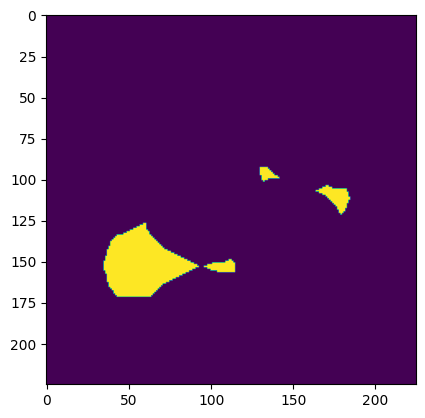

In [ ]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
big_erode = cv.erode(big_objects, kernel, iterations=7)
plt.imshow(big_erode)

Итоговое изображение получим как сумму двух изображений: с маленькими объектами и с большими объектами после обработки.

Connected components: 11


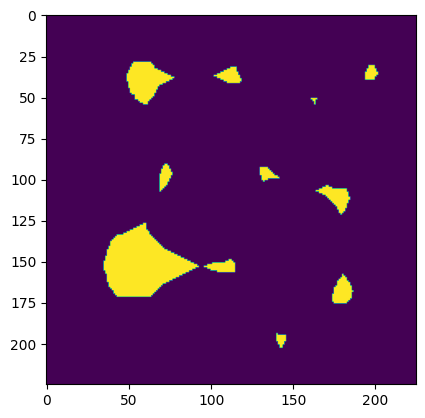

In [ ]:
res_img = np.array(small_objects + big_erode, dtype=np.uint8)
plt.imshow(res_img)

res, _ = cv.connectedComponents(res_img)
count = res - 1
print(f'Connected components: {count}')

Получили правильный ответ!

Теперь соберём все функции вместе, распространим алгоритм на все изображения из папки `white_coins/` и найдём качество.

Посмотрим, как устроен файл `coins_count_values.csv`.

In [ ]:
import pandas as pd

coin_counts = pd.read_csv("coins_count_values.csv")
print(coin_counts)

         folder      image_name  coins_count
0     all_coins  01207e3d7e.jpg            5
1     all_coins  0140acf6eb.jpg            4
2     all_coins  025c8579f0.jpg            2
3     all_coins  028ca794e7.jpg            4
4     all_coins  02e080206f.jpg           40
...         ...             ...          ...
1439  yen_coins  f8934b8498.jpg            6
1440  yen_coins  fb5981d5de.jpg            2
1441  yen_coins  fb6f6573b6.jpg            2
1442  yen_coins  fe3d6dfd45.jpg            1
1443  yen_coins  ffa5e02e21.jpg            2

[1444 rows x 3 columns]


Давайте сравним качество алгоритма подсчета монет, включая и не включая этап разделения на большие и маленькие объекты:

In [18]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results = []
ground_truth = []

coins_count = pd.read_csv("coins_count_values.csv")
paths = [os.path.join("white_coins", path) for path in os.listdir("white_coins")]
for i, img_path in enumerate(paths):
    # read and get gt value
    img = cv.imread(img_path)
    ground_truth.append(int(coins_count[coins_count["image_name"] == img_path.split("\\")[-1]]["coins_count"].values[0]))

    # make more bold
    kernel = np.ones((2,2),np.uint8)
    erosion = cv.erode(img, kernel, iterations=5)

    # grayscale
    gray = cv.cvtColor(erosion, cv.COLOR_BGR2GRAY)

    # apply threshold
    _, thresh = cv.threshold(gray, 235, 255, cv.THRESH_BINARY_INV)

    # fill holes inside
    dilate = cv.dilate(thresh, kernel, iterations=1)

    # erode to separate coins
    kernel_erode = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    errode = cv.erode(dilate, kernel_erode, iterations=11)

    # get components' area statistics
    output = cv.connectedComponentsWithStats(errode, stats=cv.CC_STAT_AREA)
    res = output[0]
    results.append(res - 1)

print(f'Accuracy: {round(np.mean(np.array(results) == np.array(ground_truth)) * 100, 2)} %')

Accuracy: 59.69 %


In [37]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results = []
ground_truth = []
recog = []

coins_count = pd.read_csv("coins_count_values.csv")
paths = [os.path.join("white_coins", path) for path in os.listdir("white_coins")]
for i, img_path in enumerate(paths):
    # read and get gt value
    img = cv.imread(img_path)
    ground_truth.append(int(coins_count[coins_count["image_name"] == img_path.split("\\")[-1]]["coins_count"].values[0]))

    # make more bold
    kernel = np.ones((2,2),np.uint8)
    erosion = cv.erode(img, kernel, iterations=5)

    # grayscale
    gray = cv.cvtColor(erosion, cv.COLOR_BGR2GRAY)

    # apply threshold
    _, thresh = cv.threshold(gray, 235, 255, cv.THRESH_BINARY_INV)

    # fill holes inside
    dilate = cv.dilate(thresh, kernel, iterations=1)

    # erode to separate coins
    # + kernel size adjustment on the grounds of image shape
    if img.shape[0] / 3 > 225:
        kernel_size = int(img.shape[0] / 225) * 3
    else:
        kernel_size = 5
    kernel_erode = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size,kernel_size))
    errode = cv.erode(dilate, kernel_erode, iterations=11)

    # get components' area statistics
    output = cv.connectedComponentsWithStats(errode, stats=cv.CC_STAT_AREA)
    res = output[0]

    if res - 1 != ground_truth[i]:
        # get only big objects and erode them more
        big_labels = np.argwhere(output[2][:,4] > 1000).flatten()
        big_objects = np.zeros(errode.shape)
        for label in big_labels:
            if label != 0:
                big_objects[output[1] == label] = 1
        kernel_erode_big = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
        big_erode = cv.erode(big_objects, kernel_erode_big, iterations=13)

        # get only small objects and erode them
        small_labels = np.argwhere(output[2][:,4] <= 1000).flatten()
        small_objects = np.zeros(errode.shape)
        for label in small_labels:
            if label != 0:
                small_objects[output[1] == label] = 1
        small_erode = cv.erode(small_objects, kernel_erode_big, iterations=2)

        # get res_img as sum of small and big objects
        res_img = np.array(small_erode + big_erode, dtype=np.uint8)
        res, _ = cv.connectedComponents(res_img)

    results.append(res - 1)
    if results[i] == ground_truth[i]:
        if res_img is not None:
            recog.append([img, res_img])
        else:
            recog.append([img, errode])
    res_img = None

print(f'Accuracy: {round(np.mean(np.array(results) == np.array(ground_truth)) * 100, 2)} %')

Accuracy: 75.19 %


Разница в 15.5% существенная!

Примеры распознанных картинок:

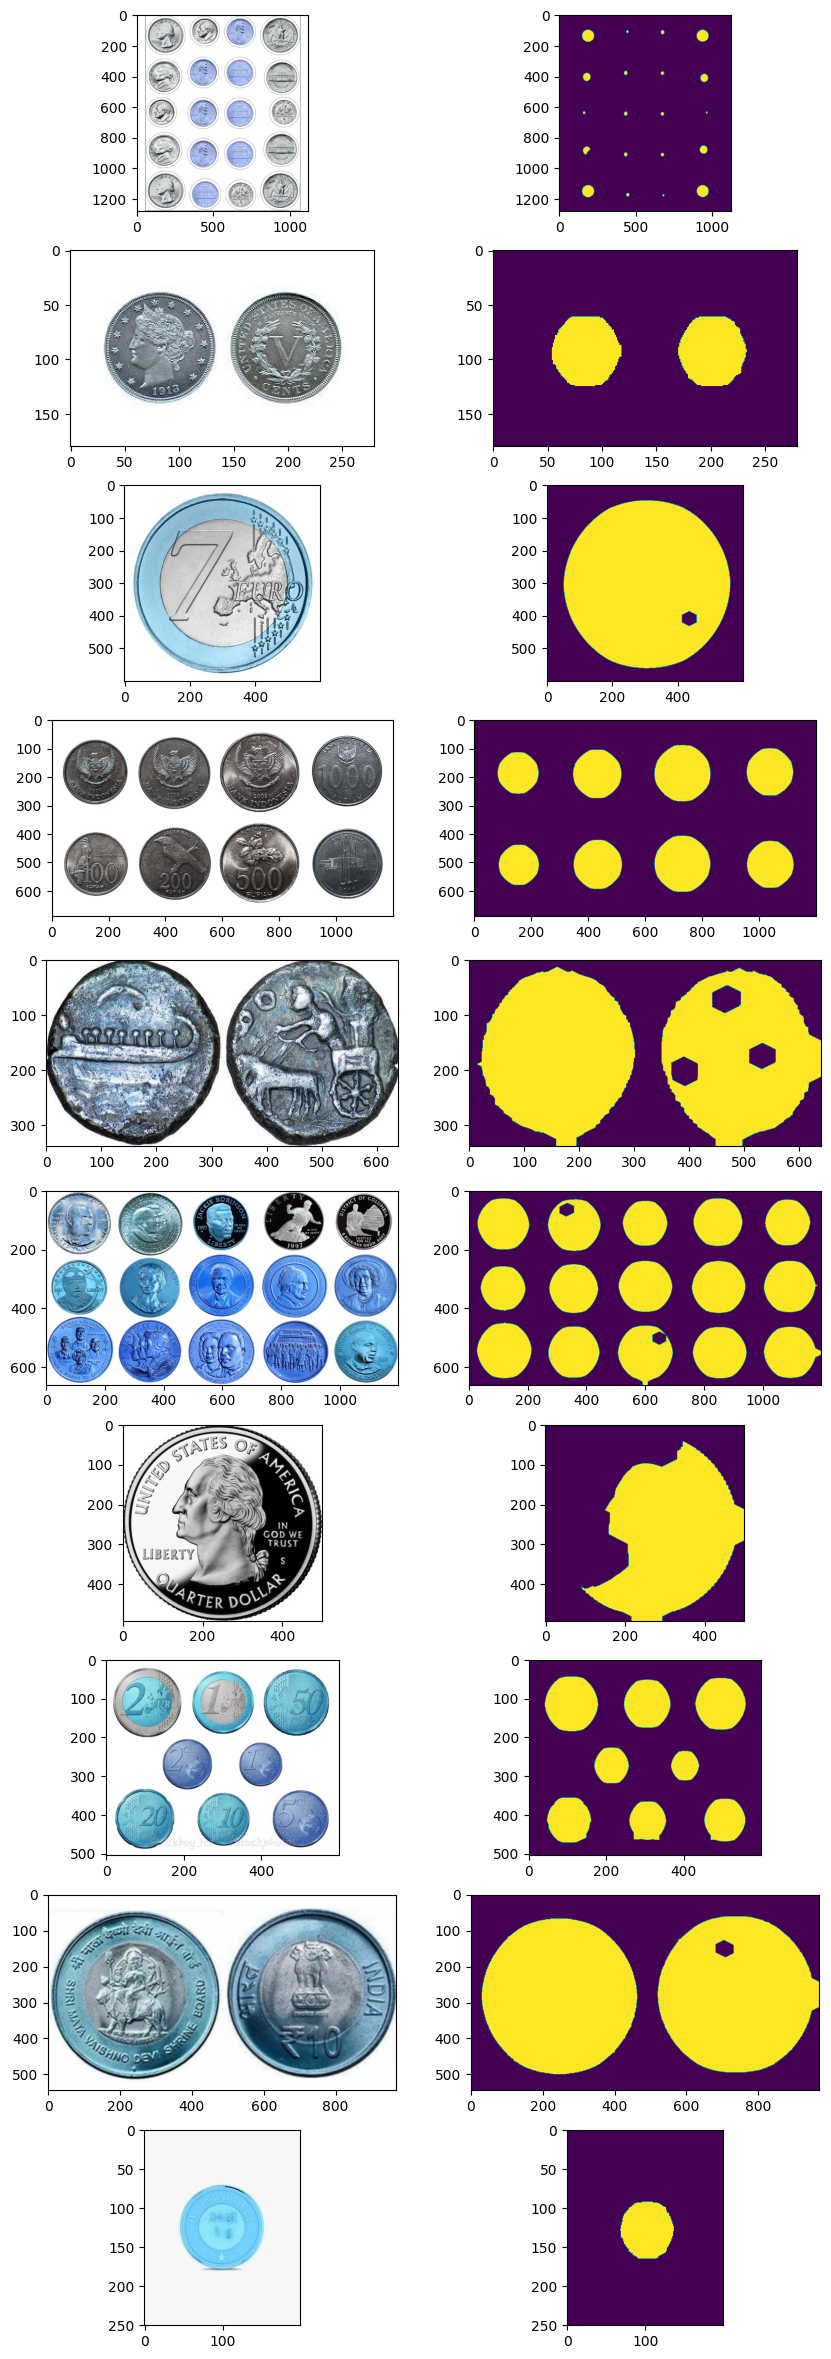

<Figure size 640x480 with 0 Axes>

In [36]:
AREA_SIZE = 10
CONSTANT_SIZE = 2

fig, axs = plt.subplots(AREA_SIZE, CONSTANT_SIZE)
fig.set_figwidth(10)
fig.set_figheight(30)
orig_fig = plt.figure()

for area_mult in range(AREA_SIZE):
        img, res = recog[20 + area_mult]
        axs[area_mult, 0].imshow(img)
        axs[area_mult, 1].imshow(res)

plt.show()